<a href="https://colab.research.google.com/github/EstebanRivera08/PyTorch_DL_coursework/blob/main/EstebanRivera_CL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 : Convolution 2D

Deyver Esteban Rivera Rodriguez - Susana Giraldo


In [24]:
# We start by importing all the libraries
#numpy and plot
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

# torch
import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn

# gzip
import gzip
import pickle

In [120]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/DPLEARNING/Convolutional Learning (CL)
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/DPLEARNING/Convolutional Learning (CL)
data/                   fashion-mnist.pk.gz     ResNet50
DL2A-lab-conv2D.ipynb   model1                  ResNet50_16ch
EstebanRivera_CL.ipynb  PyTorch_DL_coursework/


In [121]:
!git clone https://github.com/EstebanRivera08/PyTorch_DL_coursework.git

fatal: destination path 'PyTorch_DL_coursework' already exists and is not an empty directory.


# Data preparation

As a first step, the dataset was opened and turned into the variables *allXtrain, allYtrain, Xtest, Ytest* and *classlist*. The variables *allXtrain* and *allYtrain* contain all the data that will be used to train the neural network. The variables *Xtest* and *Ytest* contain all the validation data that can be used to evaluate the built model after training. The *classlist* variable is a list of all the 10 possible classes for each image.

In [27]:
# Load the dataset
fp = gzip.open('fashion-mnist.pk.gz','rb')
allXtrain, allYtrain, Xtest, Ytest, classlist  = pickle.load(fp)
# Some printed information
print('Possible classes for each image: ', classlist)
print('Training data format: ', allXtrain.shape)

Possible classes for each image:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Training data format:  torch.Size([60000, 784])


As it is possible to see, the obtained data is not in good shape for use in convolutional layers as *Convolution2D* expects a Tensor with dimensions $(N, C, H, W)$ as input. With:

- N the batch dimension, *i.e* the number of images;
- C the number of input channels, here it is 1;
- H the height or number of rows of each image;
- W the width  or number of columns of each image.

It is also possible to notice that the dataset counts with 60000 images. To get around the problem of dimensions and also to have a smaller data, and so a smaller training times, a smaller version of the dataset, containing N images, is made by slicing the original training data and the function *view* is used to reshape it to $(N, 1, 28,28)$ tensors. Initially, $N=20000$ was used.

In [28]:
N=20000
Xtrain, Ytrain  = allXtrain[:N], allYtrain[:N]
Xvalid, Yvalid  = allXtrain[N:], allYtrain[N:]
print(Xtrain.shape) # Original data shape (image made a vector)
Xtrain = Xtrain.view(N,1,28,28) # Reshape the train data (N data x 1 channel x 28 pix x 28 pix)
Xvalid = Xvalid.view(-1,1,28,28) # Reshape the validation data
print("X train shape : ", Xtrain.shape,"X valid shape : ", Xvalid.shape) # Data in good shape for convolution

torch.Size([20000, 784])
X train shape :  torch.Size([20000, 1, 28, 28]) X valid shape :  torch.Size([40000, 1, 28, 28])


# Training wrapper

To create the training model we used *negative log likelihood* as our loss function and *Adam* as our optimizer. The trainning loop is based on *gradient descent*. The training function also contains a mini-batching algorithm.

In [29]:
### The loss function
loss_fn=nn.NLLLoss()
## TODO:
import time

def train(model, epochs=30,verbose = False,lr=0.001, batch_size=200, plot = True):
    inicio = time.time()

    ## Optimizer
    optimizer=th.optim.Adam(model.parameters(),lr=lr)

    ### Mini-batching and shuffle
    Ntrain = Xtrain.shape[0]
    Nvalid = Xvalid.shape[0]
    idx = np.arange(Ntrain)
    nbatch = int(Ntrain/batch_size)

    ### store results
    train_losses,valid_losses, valid_accuracies=[],[],[]

    ########################
    # Training #############
    ########################
    for e in range(epochs):
        np.random.shuffle(idx)
        running_loss=0
        totaln = 0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size] #random batch index selection
            images = Xtrain[ids] #Batch training images
            labels = Ytrain[ids] #Batch training labels
            totaln += labels.shape[0] # the number of samples

            optimizer.zero_grad() #Reinitialize the gradient
            logprobs = model(images) #Compute the output model
            loss = loss_fn(logprobs,labels) #Compute the loss
            loss.backward() #Backward propagation
            optimizer.step()
            running_loss += loss.item() #Sum the batch loss

        # training is over for one epoch
        # now compute interesting quantities

        accuracy=0
        valid_loss = 0
        with th.no_grad(): #No necesary to update the gradient (speeds up the algorithm)

            images = Xvalid #Validation images
            labels = Yvalid #Validation labels
            logprobs = model(images)
            valid_loss = loss_fn(logprobs,labels)
            top_p,top_class = logprobs.topk(1) #Take the higher probability
            accuracy = (top_class.T == labels).sum().float()
            valid_losses.append(100*valid_loss/Nvalid)
            valid_accuracies.append(accuracy.item()*100.0/Nvalid)
        model.train()
        train_losses.append(100*running_loss/Ntrain)

        if verbose:
            print("Epoch: {}\t".format(e+1),
                      "train Loss: {:.5f}.. ".format(train_losses[-1]),
                      "valid Loss: {:.5f}.. ".format(valid_losses[-1]),
                      "valid Accuracy: {:.3f}".format(valid_accuracies[-1]))
    print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch "
          , np.fromiter(valid_accuracies, dtype=float).argmax(), " / ",epochs )

    final = time.time()
    total_time = final-inicio

    print("Run Time: {}\t".format(total_time))

    #########
    # plot ##
    #########
    if plot :
      fig, ax = plt.subplots(1,3,figsize = (9, 3),tight_layout = True)
      fig.suptitle("batch size {batch_size} and learning rate {lr}".format(batch_size=batch_size,lr=lr), fontsize=13)

      ax[0].plot(train_losses,'r')
      ax[0].set_ylabel(r" Train losses ", size=15)
      ax[0].set_xlabel(r" Epoch ", size=15)
      ax[0].grid('minor')
      ax[0].set_ylim(bottom=0)

      ax[1].plot(valid_losses,'r')
      ax[1].set_ylim(bottom=0)
      ax[1].set_ylabel(r" Valid losses ", size=15)
      ax[1].set_xlabel(r" Epoch ", size=15)
      ax[1].grid('minor')
      ax[1].set_ylim(bottom=0)

      ax[2].plot(valid_accuracies,'r')
      ax[2].set_ylim(bottom=0)
      ax[2].set_ylabel(r" Valid accuracies ", size=15)
      ax[2].set_xlabel(r" Epoch ", size=15)
      ax[2].grid('minor')
      ax[2].set_ylim(bottom=0)

      plt.show()

    return total_time

# Playing with convolution in 2D

The convolution takes as relevant parameters to this work the number of input and output channel, and the kernel, stride and padding sizes. We can see the kernel as the neural network filter which moves across the image scanning it. The padding refers to the amount of pixels we add to an image making a extention to it and is a useful tool to adjust dimensions of the output. Stride is a parameter that modifies the amount of movement we are doing over the image, and it is also an useful tool to adjust output dimensions. For a stride = 1 we can use the following relation:

$$ out_{dim} = (in_{dim}+2\times padding) - (kernel_{size}-1 )$$

torch.Size([1, 1, 28, 28])


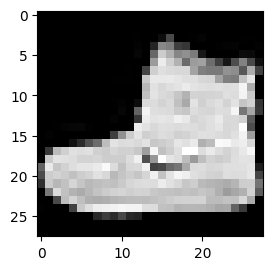

In [30]:
# We extract one image to start.
im = Xtrain[0:1] # it looks wired but we need to keep the four dimensions.
print(im.shape)  # Try with Xtrain[0] and see that it is not well suited.

plt.subplot(1,2,1)
plt.imshow(im.squeeze(),  matplotlib.pyplot.cm.gray)

Now create one convolution layer with 1 input channels, a kernel size of 3, and a stride of 1.
Try it and look at the output dimension.


torch.Size([1, 1, 26, 26])

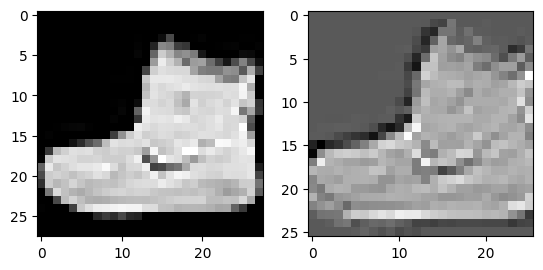

In [31]:
# We create one convolution layer with the giver parameters.
# We expect an output 26x26
Layer = nn.Conv2d(in_channels=1, out_channels=1,
                  kernel_size=3, stride=1, padding=0)
im2 = Layer(im)

plt.subplot(1,2,1)
plt.imshow(im.numpy().squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(im2.squeeze().detach().numpy() , matplotlib.pyplot.cm.gray)

im2.shape

As discussed before, to adjust the dimensions of the output we can play with padding and stride. Stride gonna reduce the size of the output, so we choose to change de padding to 1.

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


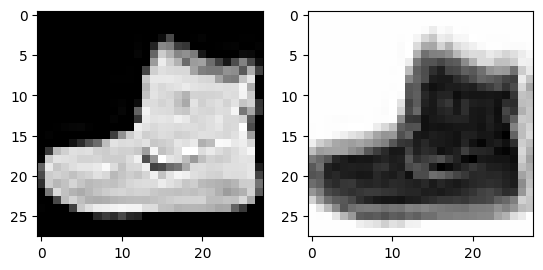

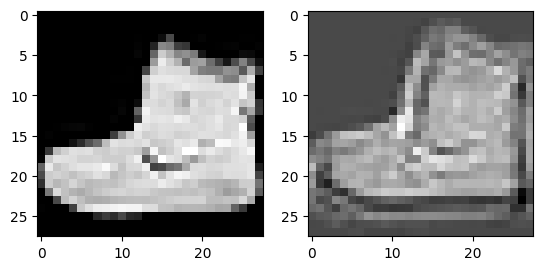

In [32]:
#
Layer = nn.Conv2d(in_channels=1, out_channels=1,
                  kernel_size=3,stride=1, padding=1)
im2 = Layer(im)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im.numpy().squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(im2.squeeze().detach().numpy() , matplotlib.pyplot.cm.gray)

print(im2.shape)

Layer = nn.Conv2d(in_channels=1, out_channels=1,
                  kernel_size=5,stride=1, padding=2)
im2 = Layer(im)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im.numpy().squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(im2.squeeze().detach().numpy() , matplotlib.pyplot.cm.gray)

print(im2.shape)

We can define the parameters of the convolutional filter with our own hands. For that purpose we just have to create the Tensor we want and cast it in a *Parameter* object (usefull for autograd) and then assign it.
This is an example:

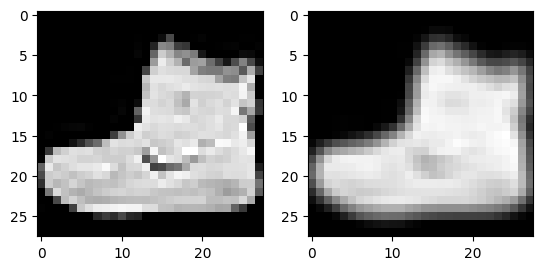

In [33]:
# Create a convolutional filter
convFilter = nn.Conv2d(in_channels=1,out_channels=1,
                       kernel_size = 3, padding=1,
                       stride=1)
# build the weight matrix you want
W=th.ones(convFilter.weight.shape)
# Makes it a Parameter and assign
convFilter.weight = nn.Parameter(W)

res = convFilter(im)
plt.subplot(1,2,1)
plt.imshow(im.squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(F.relu(res).squeeze().detach(), matplotlib.pyplot.cm.gray)

Now try to set the convolution fiter as follows:
$$
\left(
\begin{array}{ccc}
 -1 &2&-1\\
 -1 &2&-1\\
 -1 &2&-1
\end{array}
\right)
$$
and then as follows:
$$
\left(
\begin{array}{rrr}
 -1 &-1&-1\\
 2 &2&2\\
 -1 &-1&-1
\end{array}
\right)
$$
Try them on some images and visualize the results.

tensor([[[[-1.,  2., -1.],
          [-1.,  2., -1.],
          [-1.,  2., -1.]]]])


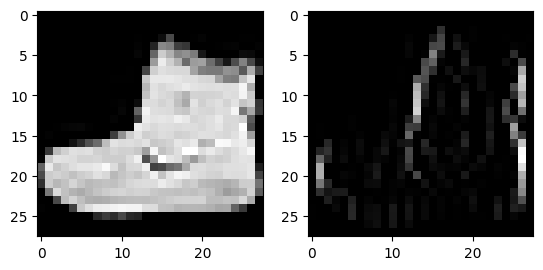

tensor([[[[-1., -1., -1.],
          [ 2.,  2.,  2.],
          [-1., -1., -1.]]]])


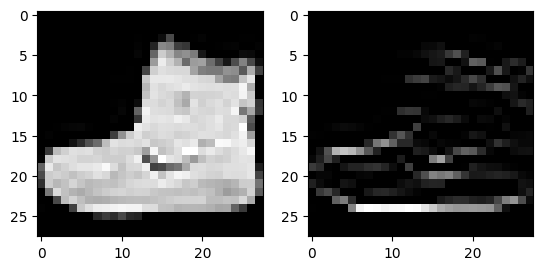

In [34]:

# build the weight matrices
W1 = W
W1[0,0,:,[0,2]] = -1
W1[0,0,:,1] = 2
print(W1)

# Makes it a Parameter and assign
convFilter.weight = nn.Parameter(W1)

plt.figure()
res = convFilter(im)
plt.subplot(1,2,1)
plt.imshow(im.squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(F.relu(res).squeeze().detach(), matplotlib.pyplot.cm.gray)
plt.show()

# build the weight matrices
W2 = W
W2[0,0,[0,2],:] = -1
W2[0,0,1,:] = 2
print(W2)

# Makes it a Parameter and assign
convFilter.weight = nn.Parameter(W2)

plt.figure()
res = convFilter(im)
plt.subplot(1,2,1)
plt.imshow(im.squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(F.relu(res).squeeze().detach(), matplotlib.pyplot.cm.gray)
plt.show()

We can see that the first filter is a vertical one and the second an horizontal one. In this way, we give preference to certains aspects of the image.

# Pool !

Pooling is a useful tool to extract relevant information from our data and also to avoid overfiting. In our case, we gonna work with max-pooling: we apply a max filter to non overlapping subregions of the image obtaining a abstract representation of it - and also a smaller image ! As we are using a 2x2 max-pooling we expect to reduce our image in a half.


torch.Size([1, 1, 14, 14])


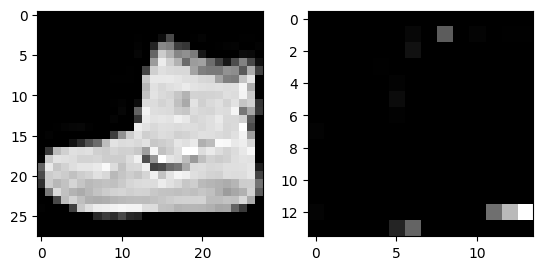

In [35]:
# We create a convolution and a max-pooling layer
conv = nn.Conv2d(1,1,3,1,1)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
relu = nn.ReLU() # Activation function

# We apply it to our image
im_conv = conv(im)
# print(im_conv.shape)
im_relu = relu(im_conv)
# print(im_relu.shape)
im_pool = pool(im_relu)
# We expect a 14x14 image
print(im_pool.shape)

# Show the result
plt.subplot(1,2,1)
plt.imshow(im.squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(im_pool.squeeze().detach(), matplotlib.pyplot.cm.gray)

#  A first model

We wrote a class whit the following architecture:

- 2D convolution with (kernel size = 3, padding = 1, stride 1)
- ReLu activation
- Max-pooling (kernel size = 2, stride 2)
- A final linear classifier
- The final activation

The class inherits from an existing class of pytorch : *Module*. This mean: it is a *Module*, but we add some peculiarities.  

In [36]:
class FashionCNN(nn.Module):

    def __init__(self, kernel_size = 3, padding= 1, out_channels = 1):
        super(FashionCNN, self).__init__()
        # Creates the convolutional layer
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels,
                              kernel_size=kernel_size, padding=padding)
        # Creates the max-pooling filter
        self.pool = nn.MaxPool2d(kernel_size = 2, stride= 2)
        self.relu = nn.ReLU() # Rectified linear unit function
        self.linear = nn.Linear(14*14*out_channels,10) # Linear classifier (14 = 28/2 new dimension because of stride)
        self.softmax = nn.LogSoftmax(dim=1) # Soft max
        self.out_ch = out_channels #Number of output channels

    # The forward loop
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1,14*14*self.out_ch)
        x = self.linear(x)
        x = self.softmax(x)
        return x

In [37]:
# Test the class: is everything in place:
# A first classifier is built like :
classif = FashionCNN()
# The parameters of the classifier are randomly initialize, but we
# can use it on a image :
out = classif.forward(im)
print(out.shape) # the output has 2 dimensions
print(out)
# We conclude that we obtained the good dimensions

torch.Size([1, 10])
tensor([[-1.8609e+01, -8.1788e+00, -2.5310e+01, -5.2349e+01, -6.4713e+01,
         -5.2922e+01, -2.8058e-04, -5.0388e+01, -1.7001e+01, -4.6896e+01]],
       grad_fn=<LogSoftmaxBackward0>)


## Training the model

As we already defined our optimizer and our loss function in our training function, we utilize the following code to train our model:



---------- Best : 82.763  at epoch  28  /  30
Run Time: 135.18196654319763	


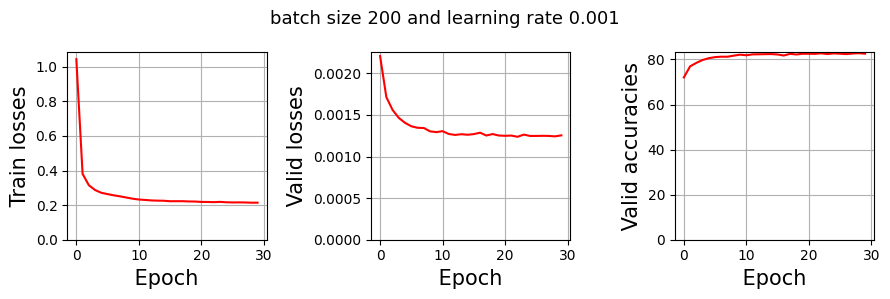

135.18196654319763

In [38]:
# Training the model
model = FashionCNN()

train(model, epochs=30,lr=0.001, batch_size=200, plot = True, verbose=False)

In [39]:
valid_labels = Yvalid
log_probs = model(Xvalid)
valid_log_probs , valid_pred = log_probs.topk(1) #Take the higher probability

valid_labels = valid_labels.squeeze().detach().numpy()
valid_pred = valid_pred.squeeze().detach().numpy()


<Axes: >

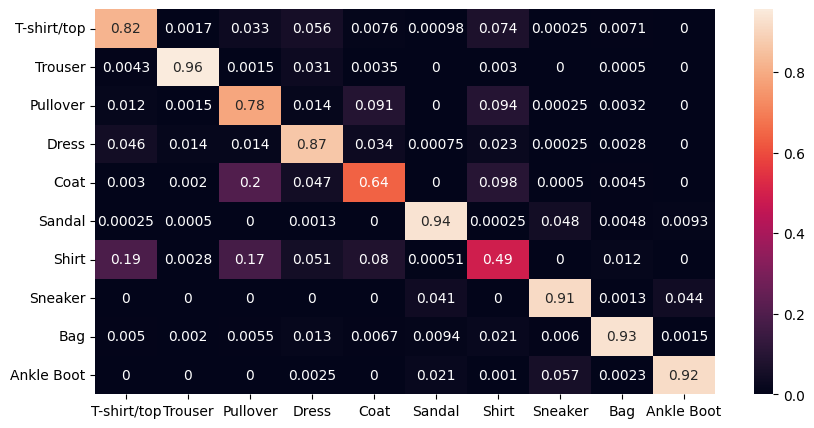

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(valid_labels, valid_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (10,5))
sn.heatmap(df_cm, annot=True)

## Batch-norm

Now, we extend the model to include the Batch-normalization. Batch normalization converts interlayer output into a more standard format reseting the distribution of it. With that, we can process the information by the subsequent layer in a more efficiently way.


In [41]:
class FashionCNN(nn.Module):

    def __init__(self, kernel_size = 3, padding= 1, out_channels = 1,):
        super(FashionCNN, self).__init__()
        # Creates the convolutional layer
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels,
                              kernel_size=kernel_size, padding=padding)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride= 2) # Creates the max-pooling filter
        self.relu = nn.ReLU() # Rectified linear unit function
        self.linear = nn.Linear(14*14,10) # Linear classifier
        self.softmax = nn.LogSoftmax(dim=1) # Soft max
        self.batchnorm = nn.BatchNorm2d(out_channels) # Batch normalization

    def forward(self, x):
        x  = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1,196)
        x = self.linear(x)
        x = self.softmax(x)
        return x

Epoch: 1	 train Loss: 0.64569..  valid Loss: 0.00193..  valid Accuracy: 74.845
Epoch: 2	 train Loss: 0.34033..  valid Loss: 0.00156..  valid Accuracy: 78.695
Epoch: 3	 train Loss: 0.29171..  valid Loss: 0.00140..  valid Accuracy: 80.600
Epoch: 4	 train Loss: 0.26838..  valid Loss: 0.00133..  valid Accuracy: 81.660
Epoch: 5	 train Loss: 0.25366..  valid Loss: 0.00128..  valid Accuracy: 82.308
Epoch: 6	 train Loss: 0.24423..  valid Loss: 0.00124..  valid Accuracy: 82.770
Epoch: 7	 train Loss: 0.23700..  valid Loss: 0.00121..  valid Accuracy: 83.132
Epoch: 8	 train Loss: 0.23060..  valid Loss: 0.00120..  valid Accuracy: 83.457
Epoch: 9	 train Loss: 0.22656..  valid Loss: 0.00119..  valid Accuracy: 83.483
Epoch: 10	 train Loss: 0.22219..  valid Loss: 0.00117..  valid Accuracy: 83.752
Epoch: 11	 train Loss: 0.21870..  valid Loss: 0.00116..  valid Accuracy: 83.728
Epoch: 12	 train Loss: 0.21567..  valid Loss: 0.00115..  valid Accuracy: 83.983
Epoch: 13	 train Loss: 0.21339..  valid Loss: 0.0

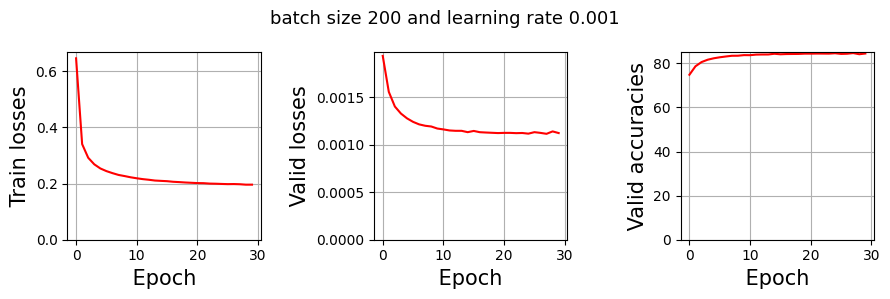

132.5854947566986

In [42]:
# Training the model
model = FashionCNN()

train(model, epochs=30,lr=0.001, batch_size=200, plot = True, verbose=True)

In [43]:
th.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DPLEARNING/Convolutional Learning (CL)/model1')

In [44]:
valid_labels = Yvalid
log_probs = model(Xvalid)
valid_log_probs , valid_pred = log_probs.topk(1) #Take the higher probability

valid_labels = valid_labels.squeeze().detach().numpy()
valid_pred = valid_pred.squeeze().detach().numpy()


<Axes: >

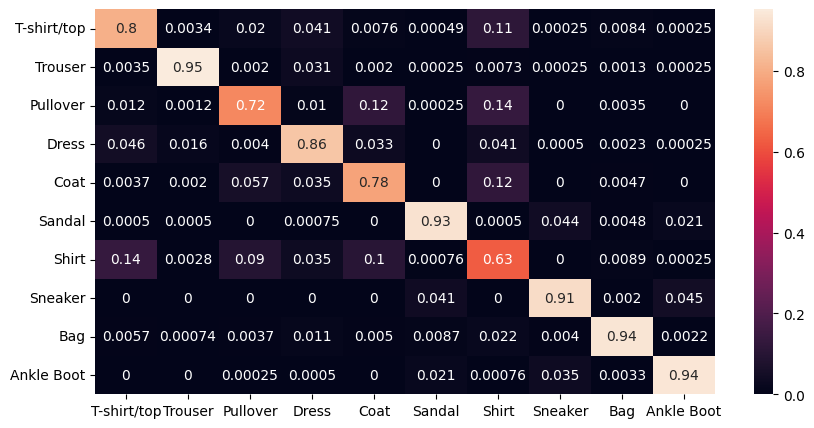

In [45]:
# Build confusion matrix
cf_matrix = confusion_matrix(valid_labels, valid_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (10,5))
sn.heatmap(df_cm, annot=True)

# More convolution and ResNet

We can now define an extended model where the basic block is : Conv2D, ReLu, BatchNorm and MaxPool.
We stack two blocks of this kind before the classification.

For instance in the previous model, this kind of block reduce the image size and increase the number of output channels. We can try to do the same and double this number in the second block.

TODO:
- Implement a model with two blocks as decribed above.
- We can then improve the output classifier.
- Play with the hyper-parameters.
- Implement a ResNet like architecture

Of course if you want to leverage a deeper model it is useful to increase the amount of training data (we only take the first 20k images until now).

For a ResNet architecture we implemented the following class using the simplified architecture sugested in the CIFAR10 notebook.

In [46]:
# ResNet
class ResNet(nn.Module):

    def __init__(self, kernel_size = 3, padding= 1, in_channels = 1, out_channels = 1, n_resblocks = 2):
        super(ResNet, self).__init__()
        # Creates the convolution of the input layer
        self.input_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                              kernel_size=kernel_size, padding=padding, bias=False)
        # Creates de cascade of residual blocks using the module defined bellow
        self.cascade = ResidualBlock(out_channels, kernel_size, padding, n_resblocks)
        self.relu = nn.ReLU() # Rectified linear unit function
        self.softmax = nn.LogSoftmax(dim=1) # Softmax
        self.batchnorm = nn.BatchNorm2d(out_channels) # Batch normalization
        self.linear = nn.Linear(28*28*out_channels,10) # Linear layer
        self.out_ch = out_channels # Number of output channels


    def forward(self, x):
        # Input layer
        x = self.input_conv(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        # Residual Blocks
        x = self.cascade(x)
        #Output layer
        x = x.view(-1,28*28*self.out_ch)
        x = self.linear(x)
        x = self.softmax(x)
        return x

# Module to create the cascade of residual blocks
class ResidualBlock(nn.Module):
    def __init__(self, out_channels, kernel_size, padding, n_resblocks ):
        super(ResidualBlock, self).__init__()
        # Convolution for each residual block
        self.conv = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                              kernel_size=kernel_size, padding=padding, bias=False)
        self.relu = nn.ReLU() # Rectified linear unit function
        self.batchnorm = nn.BatchNorm2d(out_channels) # Batch normalization
        self.N = n_resblocks # Number of residual blocks

    def forward(self, x):
        #residual block
        for i in range(self.N): # To have multiple residual blocks
            # First convolution followed by a relu and batchnorm
            out  = self.conv(x)
            out = self.relu(out)
            out = self.batchnorm(out)
            # Second convolution followed by a relu and batchnorm
            out  = self.conv(x)
            out = self.relu(out)
            out = self.batchnorm(out)
            # Output of the residual block as relu(x+f(x))
            x = self.relu(x+out)
        return x

---------- Best : 85.235  at epoch  12  /  30
Run Time: 499.24289774894714	


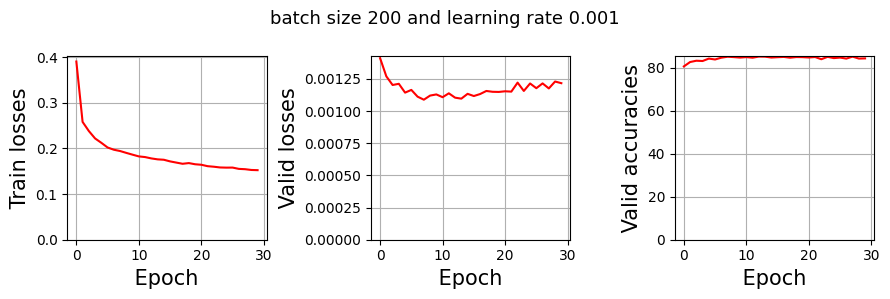

499.24289774894714

In [47]:
# Training the model !
# Training the model
model = ResNet(n_resblocks = 2)

train(model, epochs=30,lr=0.001, batch_size=200, plot = True, verbos = True)


#ResNet50 (50 layers) :

## Creation of model:

In [54]:
class conv_block(nn.Module):
    # TODO :
    def __init__(self,in_channel, f, filters, s):
        super(conv_block, self).__init__()
        F1, F2, F3 = filters
        self.block1 = nn.Sequential(nn.Conv2d(in_channels = in_channel, out_channels = F1, kernel_size = 1, stride = s, padding = 'valid'),
                      nn.BatchNorm2d(F1),
                      nn.ReLU())
        self.block2 = nn.Sequential(nn.Conv2d(in_channels = F1, out_channels = F2, kernel_size = f, stride = 1, padding = 'same'),
                      nn.BatchNorm2d(F2),
                      nn.ReLU())

        self.block3 = nn.Sequential(nn.Conv2d(in_channels = F2, out_channels = F3, kernel_size = 1, stride = 1, padding = 'valid'),
                      nn.BatchNorm2d(F3))

        self.bn = nn.Sequential(nn.Conv2d(in_channels = in_channel, out_channels = F3, kernel_size = 1, stride = s, padding = 'valid'),
                      nn.BatchNorm2d(F3))

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)

    def forward(self,x) :
     # print("convolutional")
      x_shortcut = x
     # print("conv", x.shape)
      x = self.block1(x)
     # print("conv", x.shape)
      x = self.block2(x)
     # print("conv", x.shape)
      x = self.block3(x)
      #print("conv", x.shape)
     # print("conv short", x_shortcut.shape)
      x_shortcut = self.bn(x_shortcut)
      x = th.add(x,x_shortcut)
      #print("conv", x.shape)

      return self.relu(x)



In [55]:
class identity_block(nn.Module):
    # TODO :
    def __init__(self, in_channel, f, filters):
        super(identity_block, self).__init__()
        F1, F2, F3 = filters
        self.block1 = nn.Sequential(nn.Conv2d(in_channels = in_channel, out_channels = F1, kernel_size = 1, stride = 1, padding = 'valid'),
                      nn.BatchNorm2d(F1),
                      nn.ReLU())

        self.block2 = nn.Sequential(nn.Conv2d(in_channels = F1, out_channels = F2, kernel_size = f, stride = 1, padding = 'same'),
                      nn.BatchNorm2d(F2),
                      nn.ReLU())

        self.block3 = nn.Sequential(nn.Conv2d(in_channels = F2, out_channels = F3, kernel_size = 1, stride = 1, padding = 'valid'),
                      nn.BatchNorm2d(F3))

        self.relu = nn.ReLU()

    def forward(self,x) :

      #print("identity")
      x_shortcut = x
      #print("identi",x.shape)
      x = self.block1(x)
      #print("identi",x.shape)
      x = self.block2(x)
      #print("identi",x.shape)
      x = self.block3(x)
      #print("identi",x.shape)
      x = th.add(x,x_shortcut)
      #print("identi",x.shape)

      return self.relu(x)

In [56]:
y =Xtrain[0:5]
print(y.shape)

#zero = nn.ZeroPad2d(3)
relu = nn.ReLU()
print("first block")
#y = zero(y)

in_channel = 1
out_channel = 4
first_block = nn.Sequential(nn.ZeroPad2d(3),
                            nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 7, stride = 1),
                            nn.BatchNorm2d(out_channel),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = 3, stride = 2))
y = first_block(y)


print(y.shape)

print("2 block")
F1, F2, F3 = out_channel, out_channel , out_channel*4
print("F1 , F2, F3 :", F1, F2, F3)
conv_block1 = conv_block(f = 3, filters = [F1, F2, F3], s = 1, in_channel = F1)
identity_block1 = identity_block(f = 3, filters = [F1, F2, F3], in_channel = F3)

y = conv_block1(y)
y = identity_block1(y)
y = identity_block1(y)

print(y.shape)
print("3 block")
F1, F2, F3 = F1*2, F1*2 , F1*8
print("F1 , F2, F3 :", F1, F2, F3, "test F1*2: ", F1*2)
conv_block2 = conv_block(f = 3, filters = [F1, F2, F3], s = 2, in_channel = int(F1*2))
identity_block2 = identity_block(f = 3, filters = [F1, F2, F3], in_channel = F3)

y = conv_block2(y)
y = identity_block2(y)
y = identity_block2(y)
y = identity_block2(y)

print(y.shape)

print("4 block")
F1, F2, F3 = F1*2, F1*2 , F1*8
print("F1 , F2, F3 :", F1, F2, F3, "test F1*2: ", F1*2)
conv_block3 = conv_block(f = 3, filters = [F1, F2, F3], s = 2, in_channel = int(F1*2))
identity_block3 = identity_block(f = 3, filters = [F1, F2, F3], in_channel = F3)
conv = nn.Conv2d(in_channels = F3, out_channels = F3, kernel_size = 1, stride = 1, padding = 'valid')

y = conv_block3(y)
y = identity_block3(y)
y = identity_block3(y)
y = identity_block3(y)
y = identity_block3(y)
y = identity_block3(y)

print(y.shape)

print("5 block")
F1, F2, F3 = F1*2, F1*2 , F1*8
print("F1 , F2, F3 :", F1, F2, F3, "test F1*2: ", F1*2)
conv_block4 = conv_block(f = 3, filters = [F1, F2, F3], s = 2, in_channel = int(F1*2))
identity_block4 = identity_block(f = 3, filters = [F1, F2, F3], in_channel = F3)

y = conv_block4(y)
y = identity_block4(y)
y = identity_block4(y)
print(y.shape)

print("computed size",out_channel*8*4*4, "real size", y.shape[1]*y.shape[2]*y.shape[3])
linear = nn.Linear(out_channel*8*4*4,10)
softmax = nn.LogSoftmax(dim = 1)

print("final block")
y = th.flatten(y, 1)
y = linear(y)
y = softmax(y)
print(y.shape)




torch.Size([5, 1, 28, 28])
first block
torch.Size([5, 4, 13, 13])
2 block
F1 , F2, F3 : 4 4 16
torch.Size([5, 16, 13, 13])
3 block
F1 , F2, F3 : 8 8 32 test F1*2:  16
torch.Size([5, 32, 7, 7])
4 block
F1 , F2, F3 : 16 16 64 test F1*2:  32
torch.Size([5, 64, 4, 4])
5 block
F1 , F2, F3 : 32 32 128 test F1*2:  64
torch.Size([5, 128, 2, 2])
computed size 512 real size 512
final block
torch.Size([5, 10])


In [57]:
class ResNet50(nn.Module):

    def __init__(self, in_channel = 1, out_channel = 64):
        super(ResNet50, self).__init__()

                ## FIRST BLOCK
        self.first_block = nn.Sequential(
                            nn.ZeroPad2d(3),
                            nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 7, stride = 1),
                            nn.BatchNorm2d(out_channel),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = 3, stride = 2)
                            )

        # Other functions
        self.linear = nn.Linear(out_channel*8*4*4,10)
        self.softmax = nn.LogSoftmax(dim = 1)

                ## SECOND BLOCK

        F1, F2, F3 = out_channel, out_channel , out_channel*4
        self.conv_block1 = conv_block(f = 3, filters = [F1, F2, F3], s = 1, in_channel = F1)
        self.identity_block1 = identity_block(f = 3, filters = [F1, F2, F3], in_channel = F3)

                ## THIRD BLOCK

        F1, F2, F3 = F1*2, F1*2 , F1*8
        self.conv_block2 = conv_block(f = 3, filters = [F1, F2, F3], s = 2, in_channel = int(F1*2))
        self.identity_block2 = identity_block(f = 3, filters = [F1, F2, F3], in_channel = F3)

                ## FOURTH BLOCK

        F1, F2, F3 = F1*2, F1*2 , F1*8
        self.conv_block3 = conv_block(f = 3, filters = [F1, F2, F3], s = 2, in_channel = int(F1*2))
        self.identity_block3 = identity_block(f = 3, filters = [F1, F2, F3], in_channel = F3)

                ## FIFTH BLOCK

        F1, F2, F3 = F1*2, F1*2 , F1*8
        self.conv_block4 = conv_block(f = 3, filters = [F1, F2, F3], s = 2, in_channel = int(F1*2))
        self.identity_block4 = identity_block(f = 3, filters = [F1, F2, F3], in_channel = F3)


    # Forward function for the model

    def forward(self, x):
        #print("1 block")
        x = self.first_block(x)
        #print(x.shape)

        #First stage
       # print("2 block")
        x = self.conv_block1(x)
        x = self.identity_block1(x)
        x = self.identity_block1(x)
        #print(x.shape)

        #Second stage
       # print("3 block")
        x = self.conv_block2(x)
        x = self.identity_block2(x)
        x = self.identity_block2(x)
        x = self.identity_block2(x)
        #print(x.shape)

        #First stage
        #print("4 block")
        x = self.conv_block3(x)
        x = self.identity_block3(x)
        x = self.identity_block3(x)
        x = self.identity_block3(x)
        x = self.identity_block3(x)
        x = self.identity_block3(x)
        #print(x.shape)

        #First stage
        #print("5 block")
        x = self.conv_block4(x)
        x = self.identity_block4(x)
        x = self.identity_block4(x)
       # print(x.shape)

        #print("final block")
        x = th.flatten(x,1)
        x = self.linear(x)
        x = self.softmax(x)
        #print(x.shape)
        return x

In [58]:
model = ResNet50()
x = Xtrain[1:200]

print(x.shape)
y = model(x)
print(y.shape)


torch.Size([199, 1, 28, 28])
torch.Size([199, 10])


# Training Process:

They originally make our initial features go to 64 features in the first block. We will try it going to 4 features.

In [ ]:
model = ResNet50(out_channel = 4)
x = Xtrain[1:200]
y = model(x)

print(x.shape,y.shape)

torch.Size([199, 1, 28, 28]) torch.Size([199, 10])


Epoch: 1	 train Loss: 0.89539..  valid Loss: 0.00400..  valid Accuracy: 42.380
Epoch: 2	 train Loss: 0.72650..  valid Loss: 0.00333..  valid Accuracy: 51.405
Epoch: 3	 train Loss: 0.60726..  valid Loss: 0.00288..  valid Accuracy: 57.825
Epoch: 4	 train Loss: 0.52792..  valid Loss: 0.00258..  valid Accuracy: 61.972
Epoch: 5	 train Loss: 0.47198..  valid Loss: 0.00236..  valid Accuracy: 65.210
Epoch: 6	 train Loss: 0.43489..  valid Loss: 0.00224..  valid Accuracy: 66.815
Epoch: 7	 train Loss: 0.40701..  valid Loss: 0.00213..  valid Accuracy: 68.522
Epoch: 8	 train Loss: 0.38395..  valid Loss: 0.00203..  valid Accuracy: 69.940
Epoch: 9	 train Loss: 0.36356..  valid Loss: 0.00198..  valid Accuracy: 70.745
Epoch: 10	 train Loss: 0.34722..  valid Loss: 0.00194..  valid Accuracy: 71.105
Epoch: 11	 train Loss: 0.33412..  valid Loss: 0.00189..  valid Accuracy: 71.903
Epoch: 12	 train Loss: 0.31866..  valid Loss: 0.00186..  valid Accuracy: 72.368
Epoch: 13	 train Loss: 0.30995..  valid Loss: 0.0

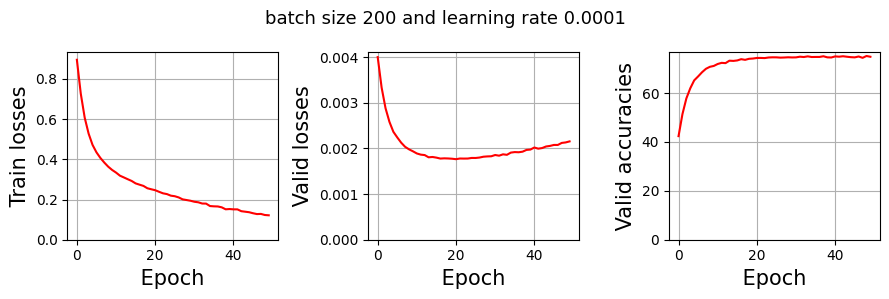

3047.5417461395264

In [ ]:
# Training the model # Training the model
train(model, epochs=50,lr=0.0001, batch_size=200, plot = True, verbose=True)

In [ ]:
th.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DPLEARNING/Convolutional Learning (CL)/ResNet50')

Now, we'll do it with 16 out features to compare the consecuences of features' increase.

Epoch: 1	 train Loss: 0.76140..  valid Loss: 0.00247..  valid Accuracy: 62.297
Epoch: 2	 train Loss: 0.40844..  valid Loss: 0.00195..  valid Accuracy: 70.312
Epoch: 3	 train Loss: 0.31273..  valid Loss: 0.00172..  valid Accuracy: 74.180
Epoch: 4	 train Loss: 0.25132..  valid Loss: 0.00170..  valid Accuracy: 74.737
Epoch: 5	 train Loss: 0.21072..  valid Loss: 0.00165..  valid Accuracy: 76.362
Epoch: 6	 train Loss: 0.17600..  valid Loss: 0.00167..  valid Accuracy: 76.825
Epoch: 7	 train Loss: 0.14389..  valid Loss: 0.00171..  valid Accuracy: 77.362
Epoch: 8	 train Loss: 0.12463..  valid Loss: 0.00177..  valid Accuracy: 77.203
Epoch: 9	 train Loss: 0.10920..  valid Loss: 0.00188..  valid Accuracy: 77.418
Epoch: 10	 train Loss: 0.08361..  valid Loss: 0.00198..  valid Accuracy: 76.885
Epoch: 11	 train Loss: 0.08111..  valid Loss: 0.00198..  valid Accuracy: 78.225
Epoch: 12	 train Loss: 0.06023..  valid Loss: 0.00208..  valid Accuracy: 78.180
Epoch: 13	 train Loss: 0.05908..  valid Loss: 0.0

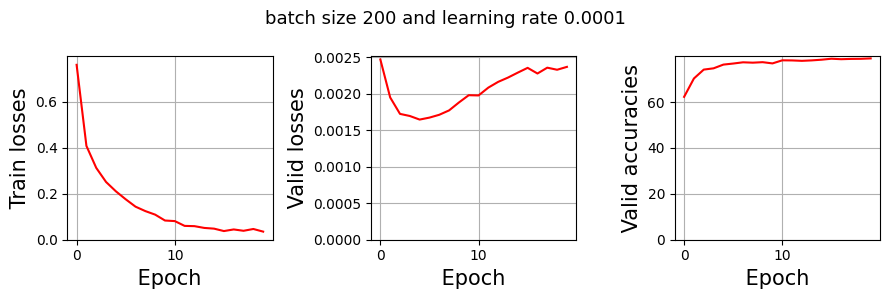

In [ ]:
model = ResNet50(out_channel = 16)
train(model, epochs=20,lr=0.0001, batch_size=200, plot = True, verbose=True)
th.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DPLEARNING/Convolutional Learning (CL)/ResNet50_16ch')

We re-train to go until 30 iterations

Epoch: 1	 train Loss: 0.18715..  valid Loss: 0.00161..  valid Accuracy: 80.100
Epoch: 2	 train Loss: 0.03324..  valid Loss: 0.00220..  valid Accuracy: 80.002
Epoch: 3	 train Loss: 0.01580..  valid Loss: 0.00241..  valid Accuracy: 80.132
Epoch: 4	 train Loss: 0.02027..  valid Loss: 0.00247..  valid Accuracy: 79.785
Epoch: 5	 train Loss: 0.02651..  valid Loss: 0.00249..  valid Accuracy: 79.752
Epoch: 6	 train Loss: 0.03553..  valid Loss: 0.00245..  valid Accuracy: 79.983
Epoch: 7	 train Loss: 0.03495..  valid Loss: 0.00242..  valid Accuracy: 80.453
Epoch: 8	 train Loss: 0.03083..  valid Loss: 0.00243..  valid Accuracy: 79.825
Epoch: 9	 train Loss: 0.02523..  valid Loss: 0.00252..  valid Accuracy: 80.358
Epoch: 10	 train Loss: 0.02769..  valid Loss: 0.00260..  valid Accuracy: 80.052
---------- Best : 80.453  at epoch  6  /  10
Run Time: 3651.5052745342255	


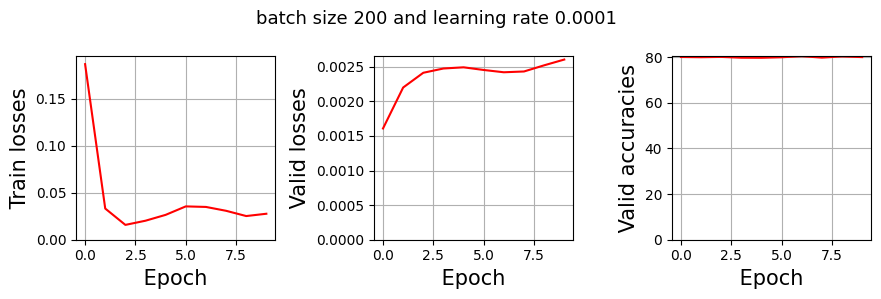

In [ ]:
model = ResNet50(out_channel = 16)
PATH = '/content/drive/MyDrive/Colab Notebooks/DPLEARNING/Convolutional Learning (CL)/ResNet50_16ch'
model.load_state_dict(th.load(PATH))
model.eval()
train(model, epochs=10,lr=0.0001, batch_size=200, plot = True, verbose=True)
th.save(model.state_dict(), PATH )

In [ ]:
model = ResNet50(out_channel = 16)
PATH = '/content/drive/MyDrive/Colab Notebooks/DPLEARNING/Convolutional Learning (CL)/ResNet50_16ch'
model.load_state_dict(th.load(PATH))
model.eval()

ResNet50(
  (first_block): Sequential(
    (0): ZeroPad2d((3, 3, 3, 3))
    (1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
  (conv_block1): conv_block(
    (block1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block3): Sequential(
      (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (1): BatchN

In [ ]:
batch_valid = 1000
idx = np.arange(Xvalid.shape[0])
np.random.shuffle(idx)

valid_labels = Yvalid[:batch_valid]
log_probs = model(Xvalid[:batch_valid])
valid_log_probs , valid_pred = log_probs.topk(1) #Take the higher probability

valid_labels = valid_labels.squeeze().detach().numpy()
valid_pred = valid_pred.squeeze().detach().numpy()

<Axes: >

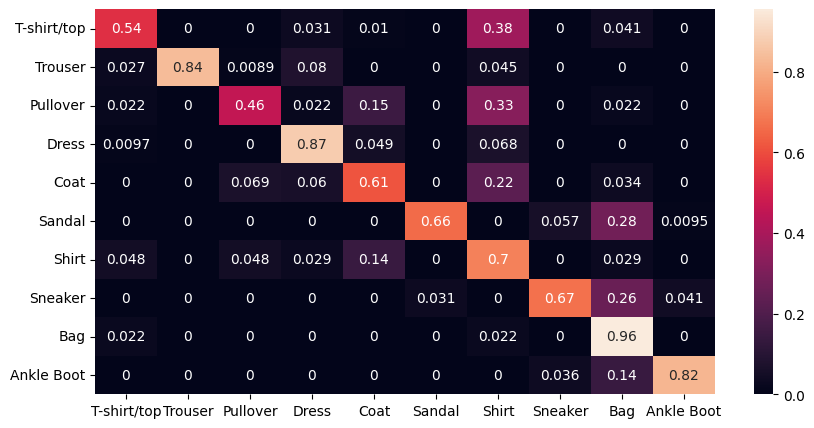

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(valid_labels, valid_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (10,5))
sn.heatmap(df_cm, annot=True)

In [ ]:
# compute the PCA in 2D
from sklearn.decomposition import PCA

xvalid = Xvalid[:batch_valid].view(-1,1*28*28)
xvalid = xvalid.detach().numpy()
pca = PCA(n_components = 2)

print(xvalid.shape)

Xvalid_PCA = pca.fit_transform(xvalid)

xvalid_pred

print(Xvalid_PCA.shape)

print(len(classes), classes[1])


(1000, 784)
(1000, 2)
10 Trouser


Text(0.5, 1.0, 'Original labels')

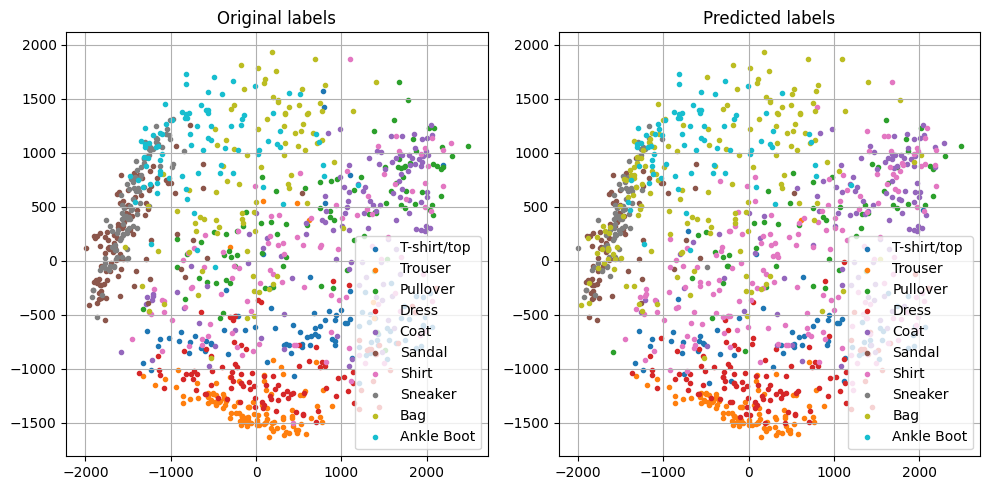

In [ ]:

#Graph
T = 10
fig, axs = plt.subplots(1,2,figsize = (T, T/2),tight_layout = True)

for i in range(len(classes)):
  axs[1].scatter(Xvalid_PCA[valid_pred == i,0],Xvalid_PCA[valid_pred == i,1], marker ='.', label = classes[i])
  axs[0].scatter(Xvalid_PCA[valid_labels == i,0],Xvalid_PCA[valid_labels == i,1], marker = '.', label = classes[i])

axs[0].grid('minor')
axs[0].legend()
axs[1].set_title('Predicted labels')

axs[1].grid('minor')
axs[1].legend()
axs[0].set_title('Original labels')

# And now in color: CIFAR-10


To experiment image classification on a coloured image, we can use the CIFAR-10 dataset.
You can find more details for instance on this page: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. We can download the dataset with a dataloader directly:

In [48]:
import torchvision
import torchvision.transforms as transforms

# The data !

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 500

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = th.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = th.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


With this example we will use a **dataset** via a *dataloader*.  This is a convenient tool to handle datasets with efficient iterators.

In [49]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


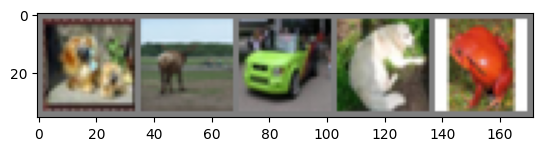

In [50]:
# A quick view of images
train_data = iter(trainloader)
images, labels = next(train_data)
imshow(torchvision.utils.make_grid(images[0:5]))

Dimension of each image tensor:  torch.Size([1, 3, 32, 32])
Class of the image:  dog


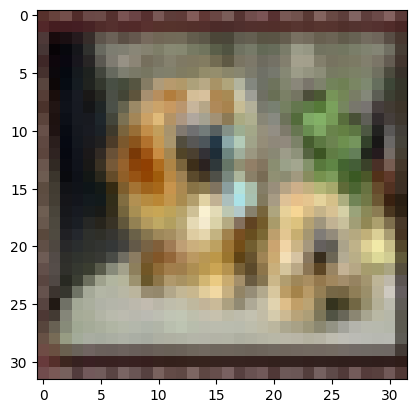

In [51]:
# Now we have colored 32x32 images (3 channels)
print('Dimension of each image tensor: ', images[0:1].shape)
print('Class of the image: ', classes[labels[0].item()])
imshow(torchvision.utils.make_grid(images[0]))pr

# Todo

Implement two convolutional architectures on this dataset:
- ResNet
- VGG 16

Try to get state of the art performance.

In [52]:
import torchvision.models as models

device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [59]:
ResNet50_16ch = ResNet50(out_channel = 16)
PATH = '/content/drive/MyDrive/Colab Notebooks/DPLEARNING/Convolutional Learning (CL)/ResNet50_16ch'
ResNet50_16ch.load_state_dict(th.load(PATH))
ResNet50_16ch.eval()

ResNet50(
  (first_block): Sequential(
    (0): ZeroPad2d((3, 3, 3, 3))
    (1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
  (conv_block1): conv_block(
    (block1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block3): Sequential(
      (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (1): BatchN

In [60]:
VGG16 = models.vgg16(pretrained = True)
VGG16.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 99.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [61]:
ResNet50 = models.resnet50(pretrained = True)
ResNet50_16ch.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


ResNet50(
  (first_block): Sequential(
    (0): ZeroPad2d((3, 3, 3, 3))
    (1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
  (conv_block1): conv_block(
    (block1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block3): Sequential(
      (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (1): BatchN

In [63]:
print("input size : ", images.shape)

ResNet50_out = ResNet50(images)
VGG16_out = VGG16(images)

print("ResNet50 output size : ", ResNet50_out.shape)
print("VGG16 output size : ", VGG16_out.shape)


input size :  torch.Size([500, 3, 32, 32])
ResNet50 output size :  torch.Size([500, 1000])
VGG16 output size :  torch.Size([500, 1000])


In [71]:
from torchvision.models.quantization import resnet50, ResNet50_QuantizedWeights

# Step 1: Initialize model with the best available weights
weights = ResNet50_QuantizedWeights.DEFAULT
model = resnet50(weights=weights, quantize=True)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = images